<a href="https://colab.research.google.com/github/Nihadto/myfirstrep/blob/main/Copy_of_ni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 74.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011719 sha256=0f69dfc593b0c216ce3e9eef948788d871b35d390689aba719d04a3c89dcd0f0
  Stored in directory: /root/.cache/pip/wheels/ef/b5/d6/ea02c4952bc1e4a25991ccf516898133191812fb2a716403f7
Successfully built en_core_web_sm
  Attempting uninstall: en_core_web_sm
    Found existing installation: en_core_web_sm 3.8.0
    Uninstalling en_core_web_sm-3.8.0:
      Successfully uninstalled en_core_web_sm-3.8.0


/usr/local/lib/python3.11/dist-packages/spacy/util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.8.4,<3.9.0
  warnings.warn(warn_msg)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spacy

In [ ]:
trainv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train (1).csv')
testv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test (2).csv')

In [ ]:
display(trainv.sample(5))
display(testv.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


In [ ]:
print(trainv.shape)
print(testv.shape)

(7613, 5)
(3263, 4)


In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

trainv['text_clean'] = trainv['text'].apply(lambda x: remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk

# Remove existing punkt data (if any)
nltk.download('punkt', force=True)

# Download all punkt sub-resources (including language-specific tables)
nltk.download('punkt_tab', quiet=True)  # Explicitly download tables

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [ ]:
trainv['lower'] = trainv['tokenized'].apply(
    lambda x: [word.lower() for word in x])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


In [ ]:
trainv['stopwords_removed'] = trainv['lower'].apply(
    lambda x: [word for word in x if word not in stop])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')  # For POS tagging
nltk.download('punkt')  # For tokenization (if not already installed)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [ ]:
import nltk
from nltk import pos_tag

In [ ]:
import nltk
import shutil

# Remove all NLTK data
nltk_dir = nltk.data.path[0]
shutil.rmtree(nltk_dir, ignore_errors=True)

# Redownload essential packages
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger', force=True)
nltk.download('wordnet', force=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
print("NLTK data paths:", nltk.data.path)
print("Tagger exists:", nltk.data.find('taggers/averaged_perceptron_tagger'))

NLTK data paths: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']
Tagger exists: /root/nltk_data/taggers/averaged_perceptron_tagger


In [ ]:
import nltk
import shutil
import os

# Remove all NLTK data
nltk_dir = os.path.join(os.path.expanduser('~'), 'AppData', 'Roaming', 'nltk_data')
shutil.rmtree(nltk_dir, ignore_errors=True)

# Set new download path
new_nltk_dir = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(new_nltk_dir, exist_ok=True)
nltk.data.path.append(new_nltk_dir)

In [ ]:
# Download with progress bars
nltk.download('punkt', download_dir=new_nltk_dir)
nltk.download('averaged_perceptron_tagger', download_dir=new_nltk_dir)

# Verify
print("Punkt installed:", nltk.data.find('tokenizers/punkt'))
print("Tagger installed:", nltk.data.find('taggers/averaged_perceptron_tagger'))

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Punkt installed: /root/nltk_data/tokenizers/punkt
Tagger installed: /root/nltk_data/taggers/averaged_perceptron_tagger


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /content/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.1 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en_core_web_sm 2.2.5
    Uninstalling en_core_web_sm-2.2.5:
      Successfully uninstalled en_core_web_sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# Load the English model
nlp = spacy.load("en_core_web_sm")

def get_spacy_pos(tokens):
    """Convert token list to POS tags using spaCy"""
    doc = nlp(" ".join(tokens))
    return [(token.text, token.pos_) for token in doc]

# Apply to your DataFrame
trainv['pos_tags'] = trainv['stopwords_removed'].apply(get_spacy_pos)

# Verify it worked
print(trainv[['stopwords_removed', 'pos_tags']].head(2))

                                   stopwords_removed  \
0  [deeds, reason, earthquake, may, allah, forgiv...   
1      [forest, fire, near, la, ronge, sask, canada]   

                                            pos_tags  
0  [(deeds, VERB), (reason, NOUN), (earthquake, N...  
1  [(forest, NOUN), (fire, NOUN), (near, ADP), (l...  


In [ ]:
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, VERB), (reason, NOUN), (earthquake, N..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, NOUN), (fire, NOUN), (near, ADP), (l..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NOUN), (asked, VERB), (shelter, N..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, NUM), (people, NOUN), (receive, VERB)..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, AUX), (sent, VERB), (photo, PROPN), (ru..."


In [ ]:
import nltk
nltk.download('wordnet')
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
trainv['wordnet_pos'] = trainv['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

trainv.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, VERB), (reason, NOUN), (earthquake, N...","[(deeds, v), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, NOUN), (fire, NOUN), (near, ADP), (l...","[(forest, n), (fire, n), (near, n), (la, n), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NOUN), (asked, VERB), (shelter, N...","[(residents, n), (asked, v), (shelter, n), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, NUM), (people, NOUN), (receive, VERB)...","[(13000, n), (people, n), (receive, v), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, AUX), (sent, VERB), (photo, PROPN), (ru...","[(got, n), (sent, v), (photo, n), (ruby, n), (..."


In [ ]:
wnl = WordNetLemmatizer()

trainv['lemmatized'] = trainv['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

trainv['lemmatized'] = trainv['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

trainv['lemma_str'] = [' '.join(map(str, l)) for l in trainv['lemmatized']]

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, VERB), (reason, NOUN), (earthquake, N...","[(deeds, v), (reason, n), (earthquake, n), (ma...","[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, NOUN), (fire, NOUN), (near, ADP), (l...","[(forest, n), (fire, n), (near, n), (la, n), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NOUN), (asked, VERB), (shelter, N...","[(residents, n), (asked, v), (shelter, n), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, NUM), (people, NOUN), (receive, VERB)...","[(13000, n), (people, n), (receive, v), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, AUX), (sent, VERB), (photo, PROPN), (ru...","[(got, n), (sent, v), (photo, n), (ruby, n), (...","[got, send, photo, ruby, alaska, smoke, wildfi...",got send photo ruby alaska smoke wildfire pour...


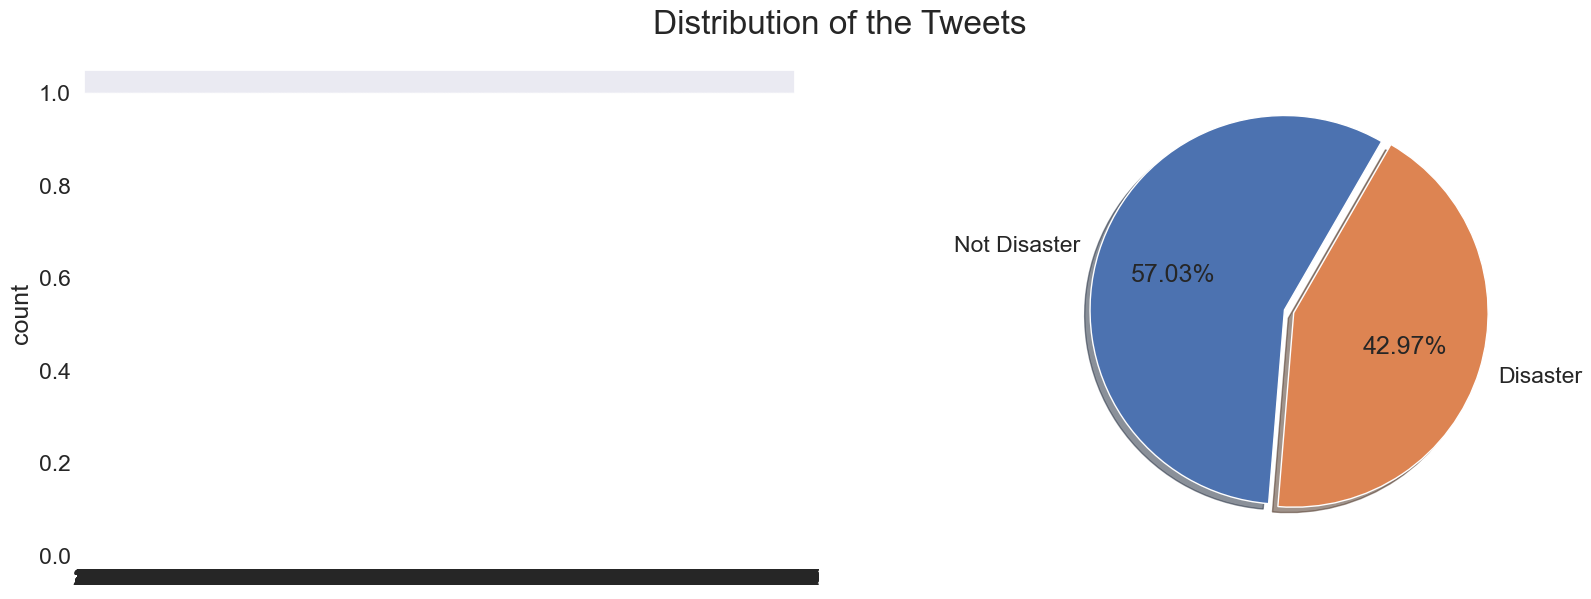

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(trainv['target'], ax=axes[0])
axes[1].pie(trainv['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [ ]:
trainv['Character Count'] = trainv['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

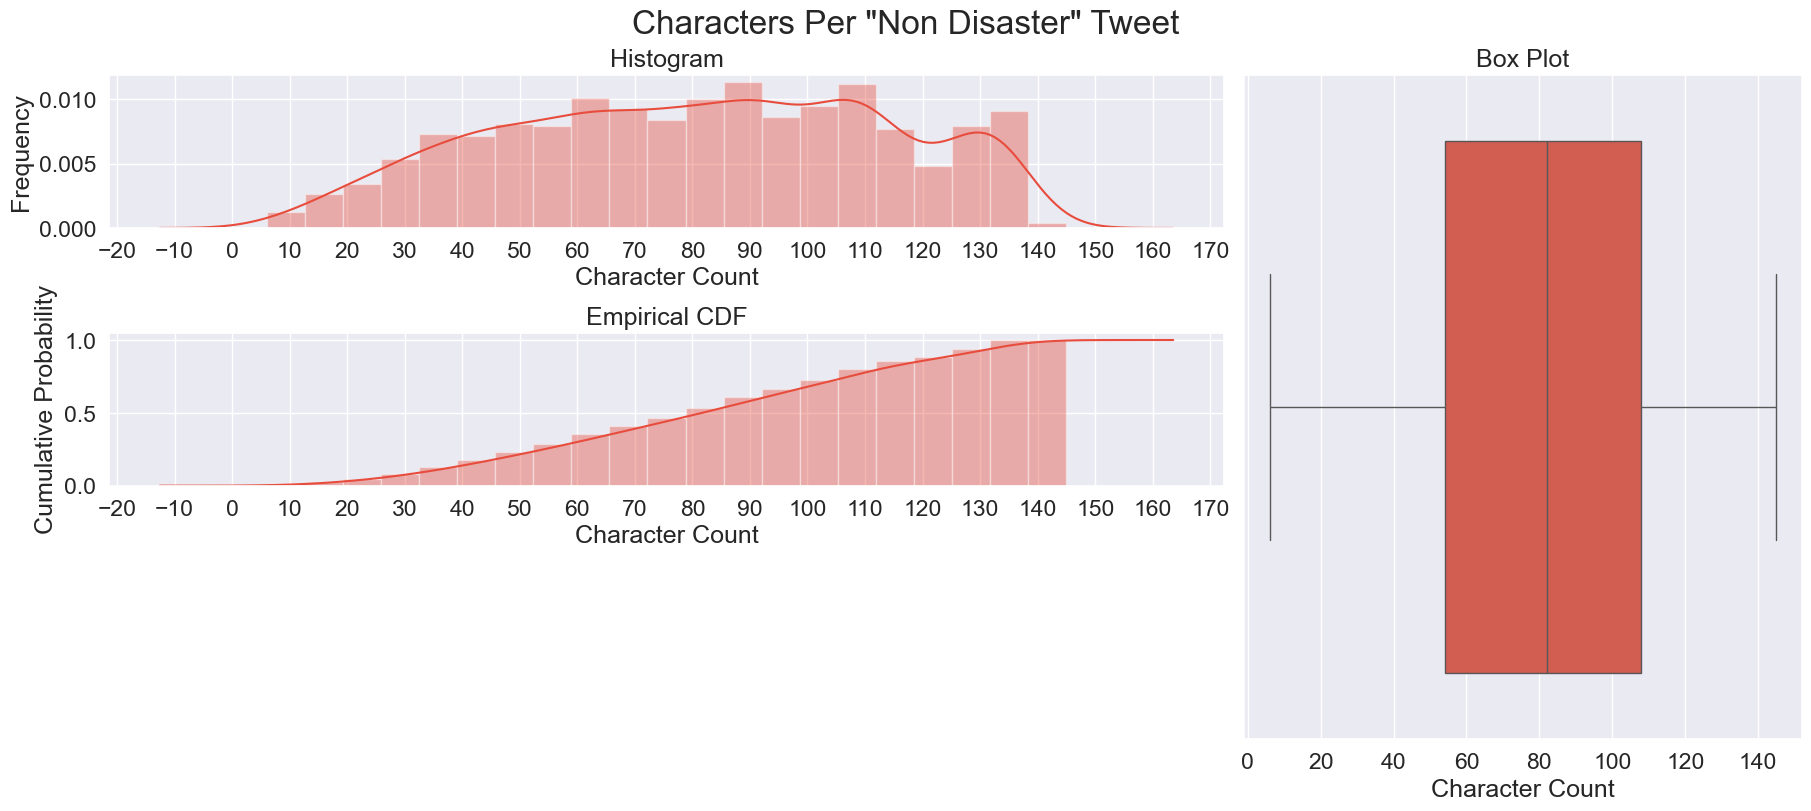

In [ ]:
plot_dist3(trainv[trainv['target'] == 0], 'Character Count',
           'Characters Per "Non Disaster" Tweet')

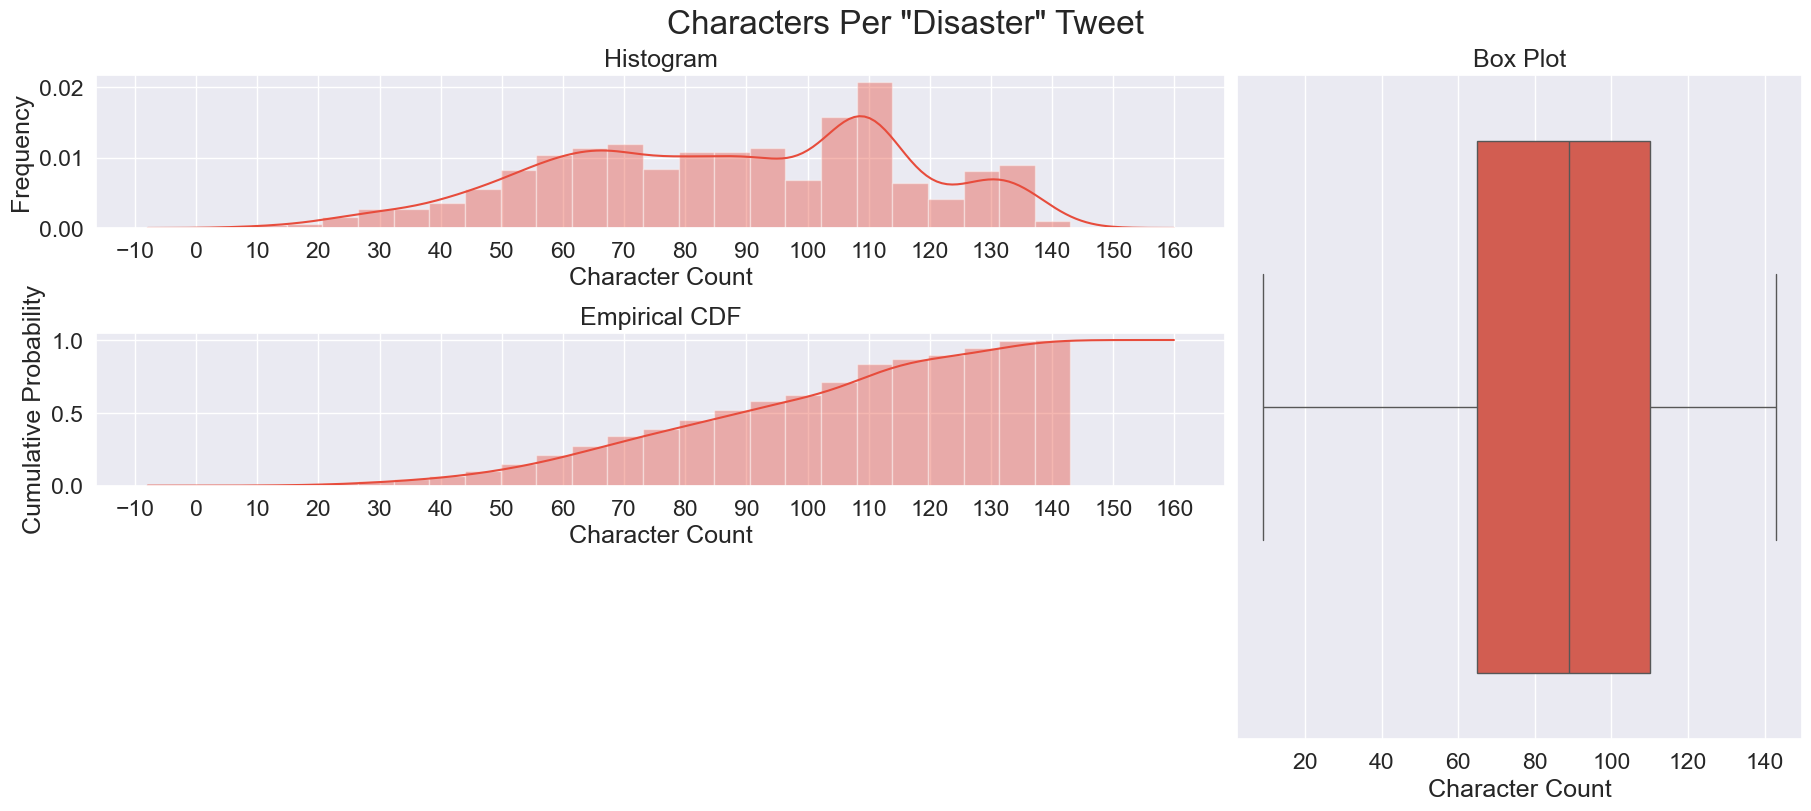

In [ ]:
plot_dist3(trainv[trainv['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

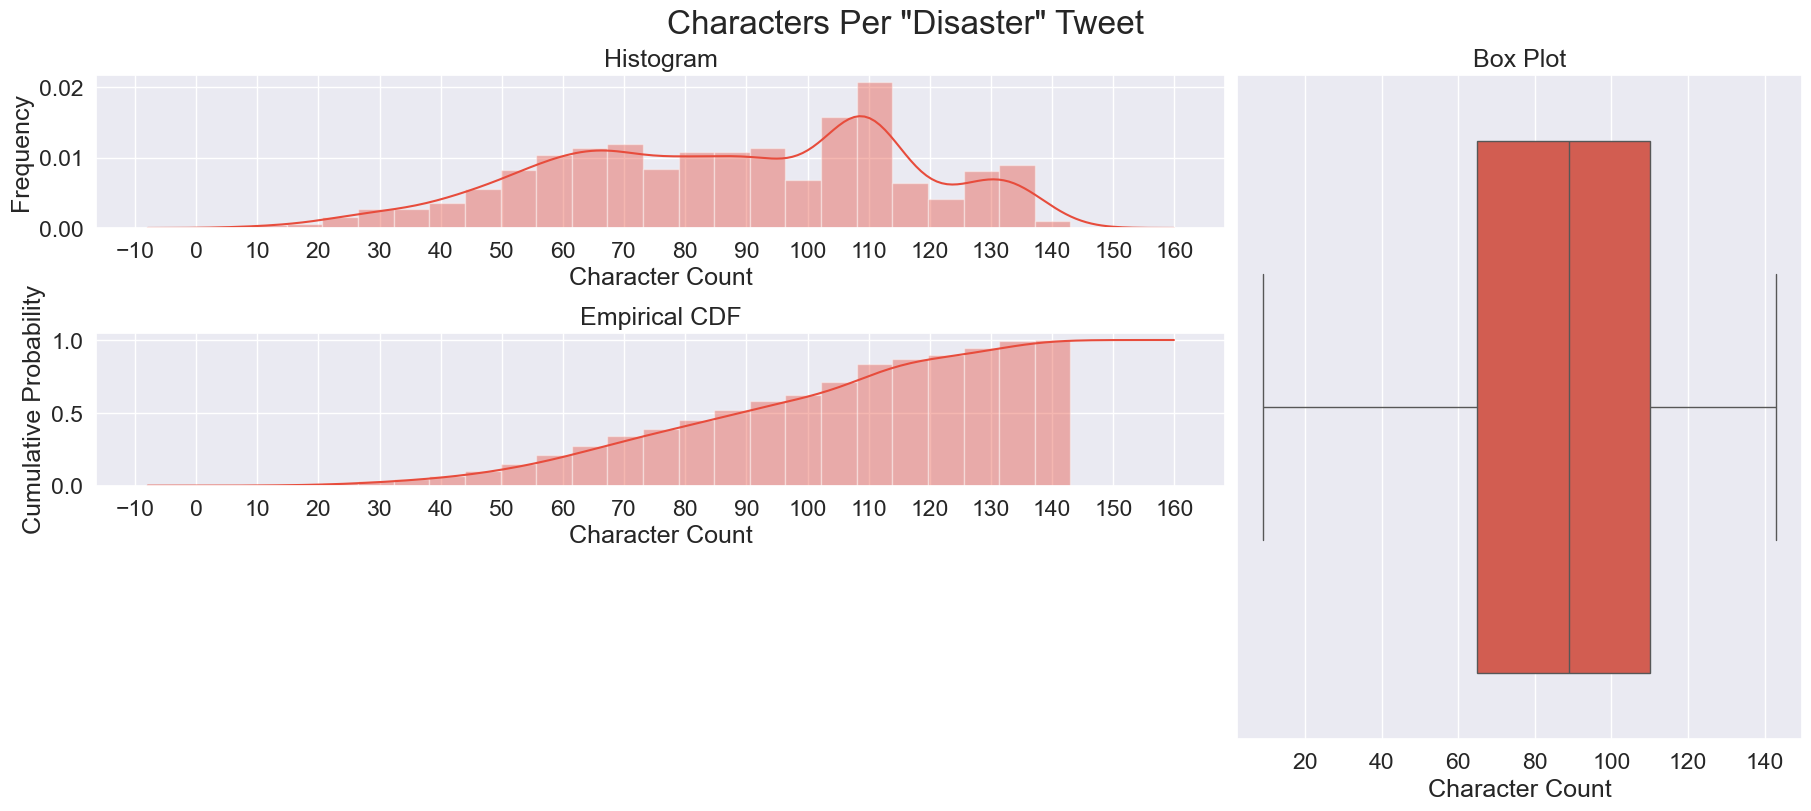

In [ ]:
plot_dist3(trainv[trainv['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

In [ ]:
def plot_word_number_histogram(textno, textye):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')

    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')

    fig.tight_layout()

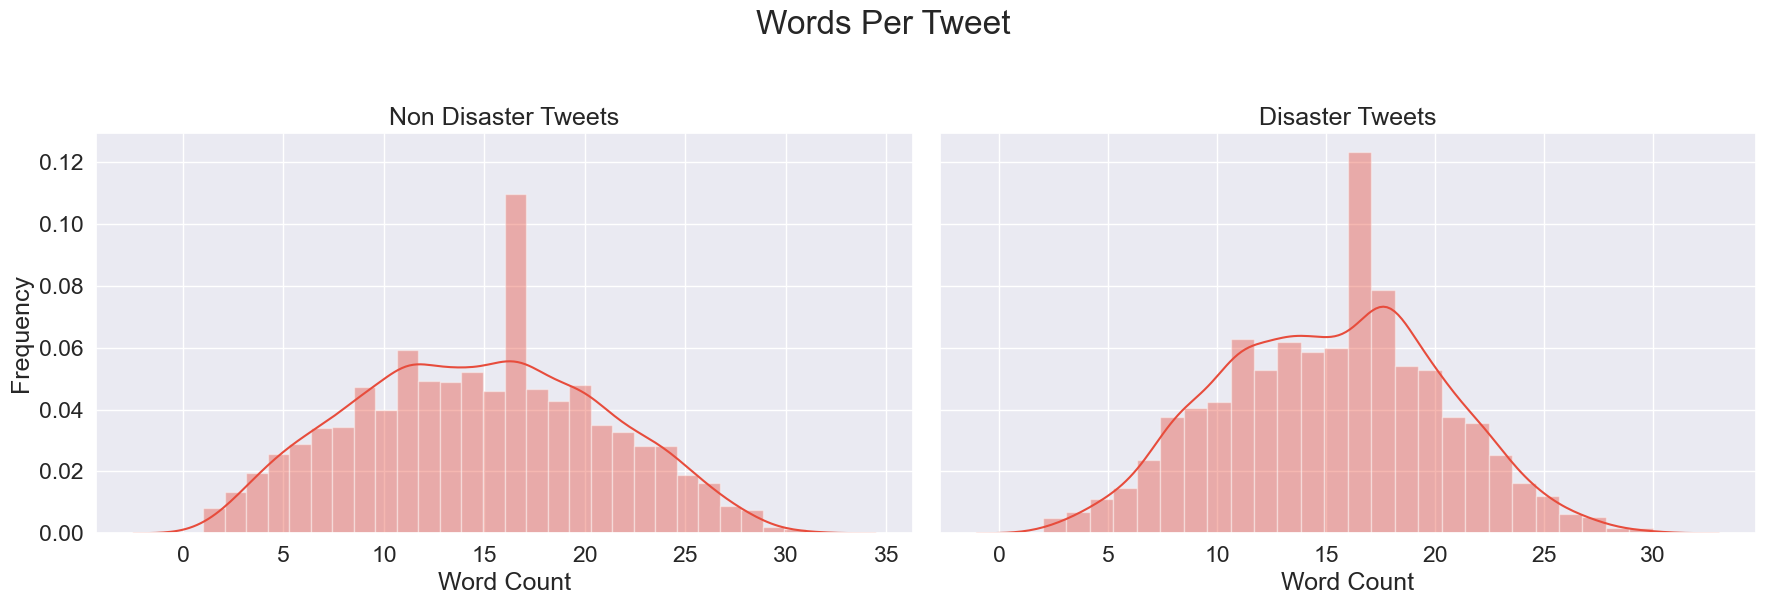

In [ ]:
plot_word_number_histogram(trainv[trainv['target'] == 0]['text'],
                           trainv[trainv['target'] == 1]['text'])

In [ ]:
def plot_word_len_histogram(textno, textye):

    """A function for comparing average word length"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')

    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()


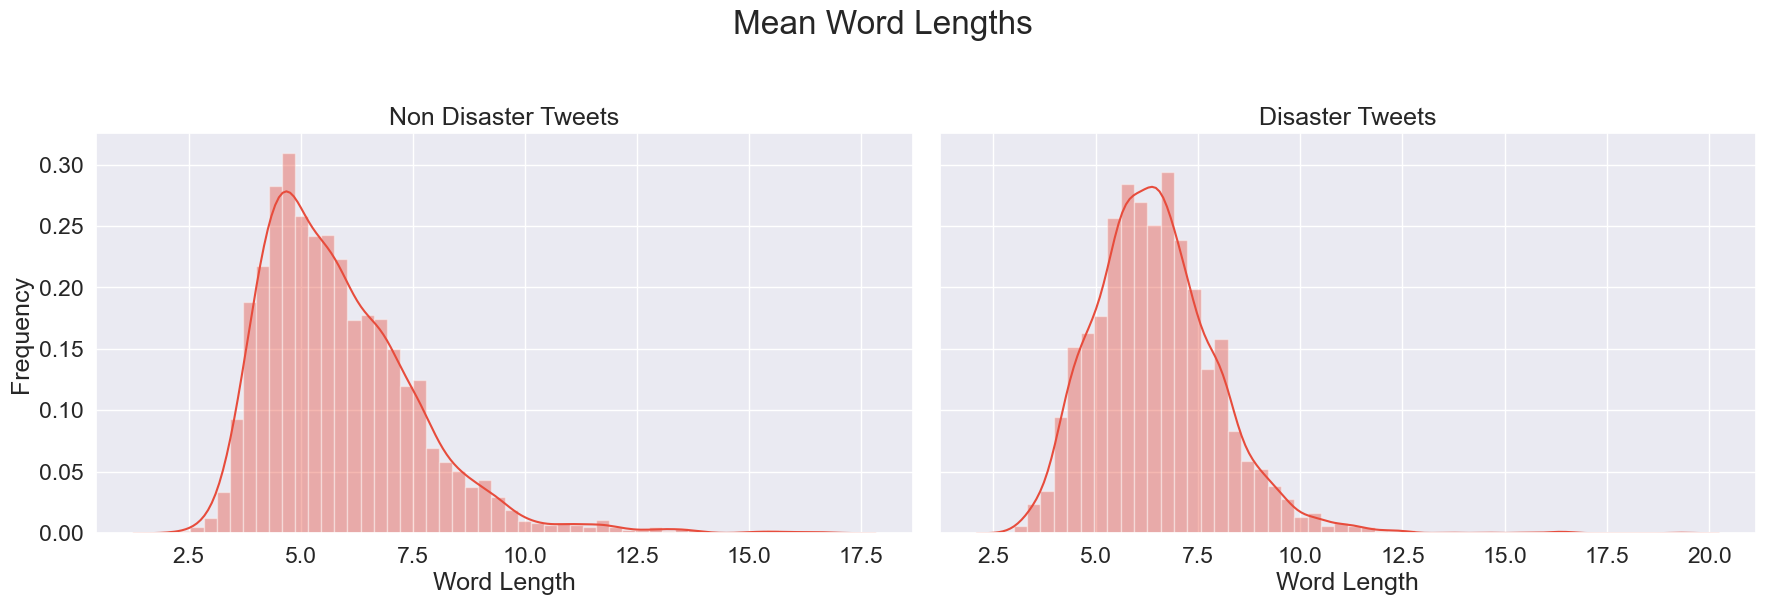

In [ ]:
plot_word_len_histogram(trainv[trainv['target'] == 0]['text'],
                        trainv[trainv['target'] == 1]['text'])

In [ ]:
lis = [
    trainv[trainv['target'] == 0]['lemma_str'],
    trainv[trainv['target'] == 1]['lemma_str']
]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


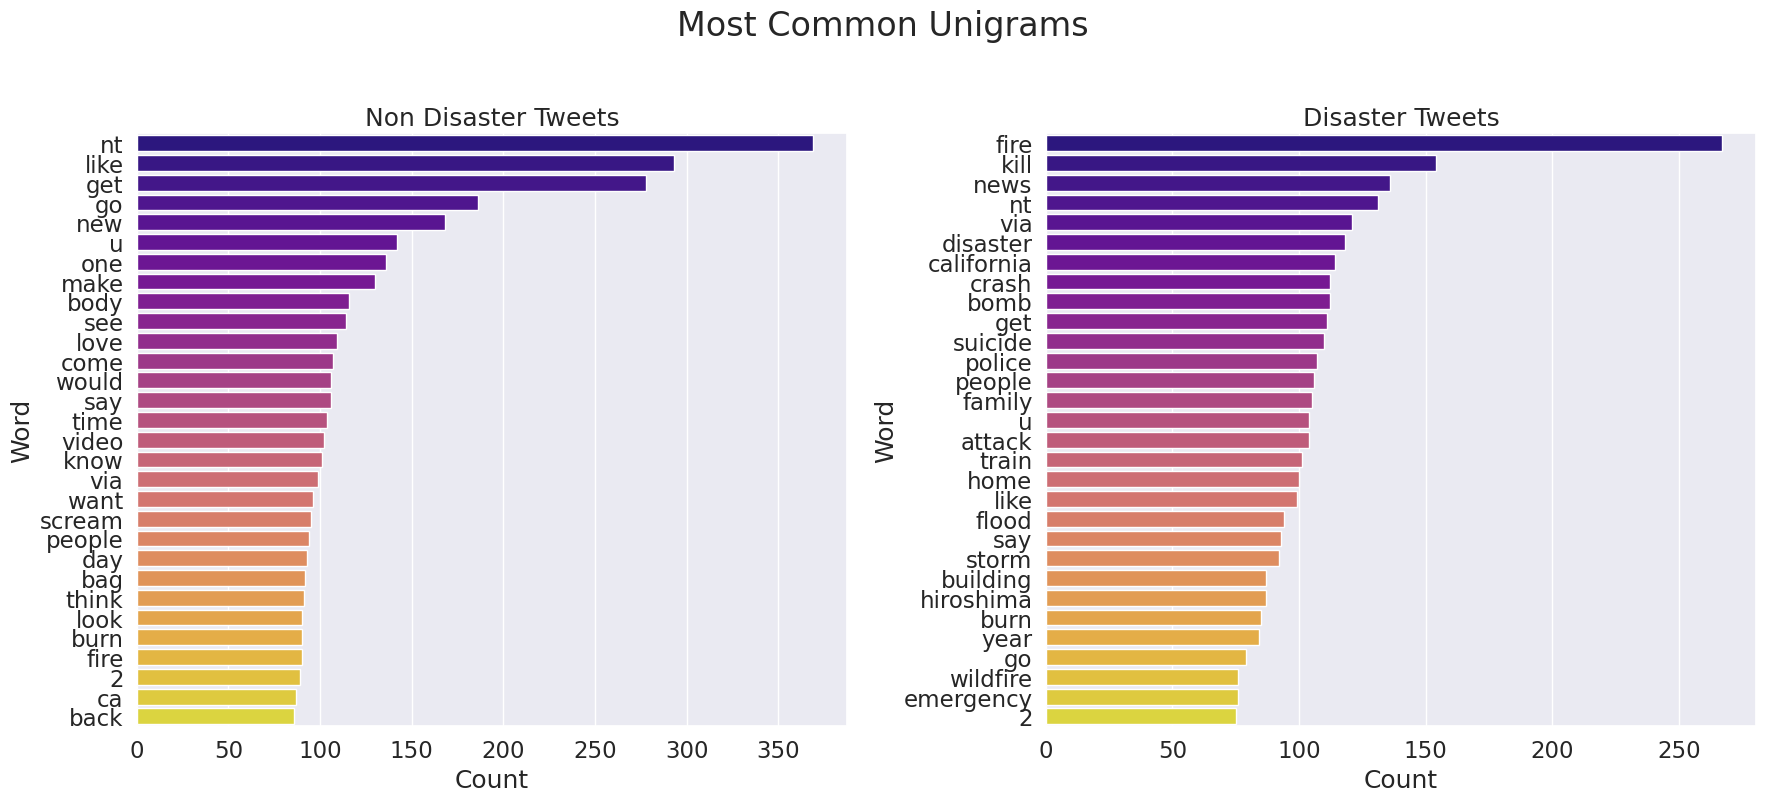

In [ ]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)

        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

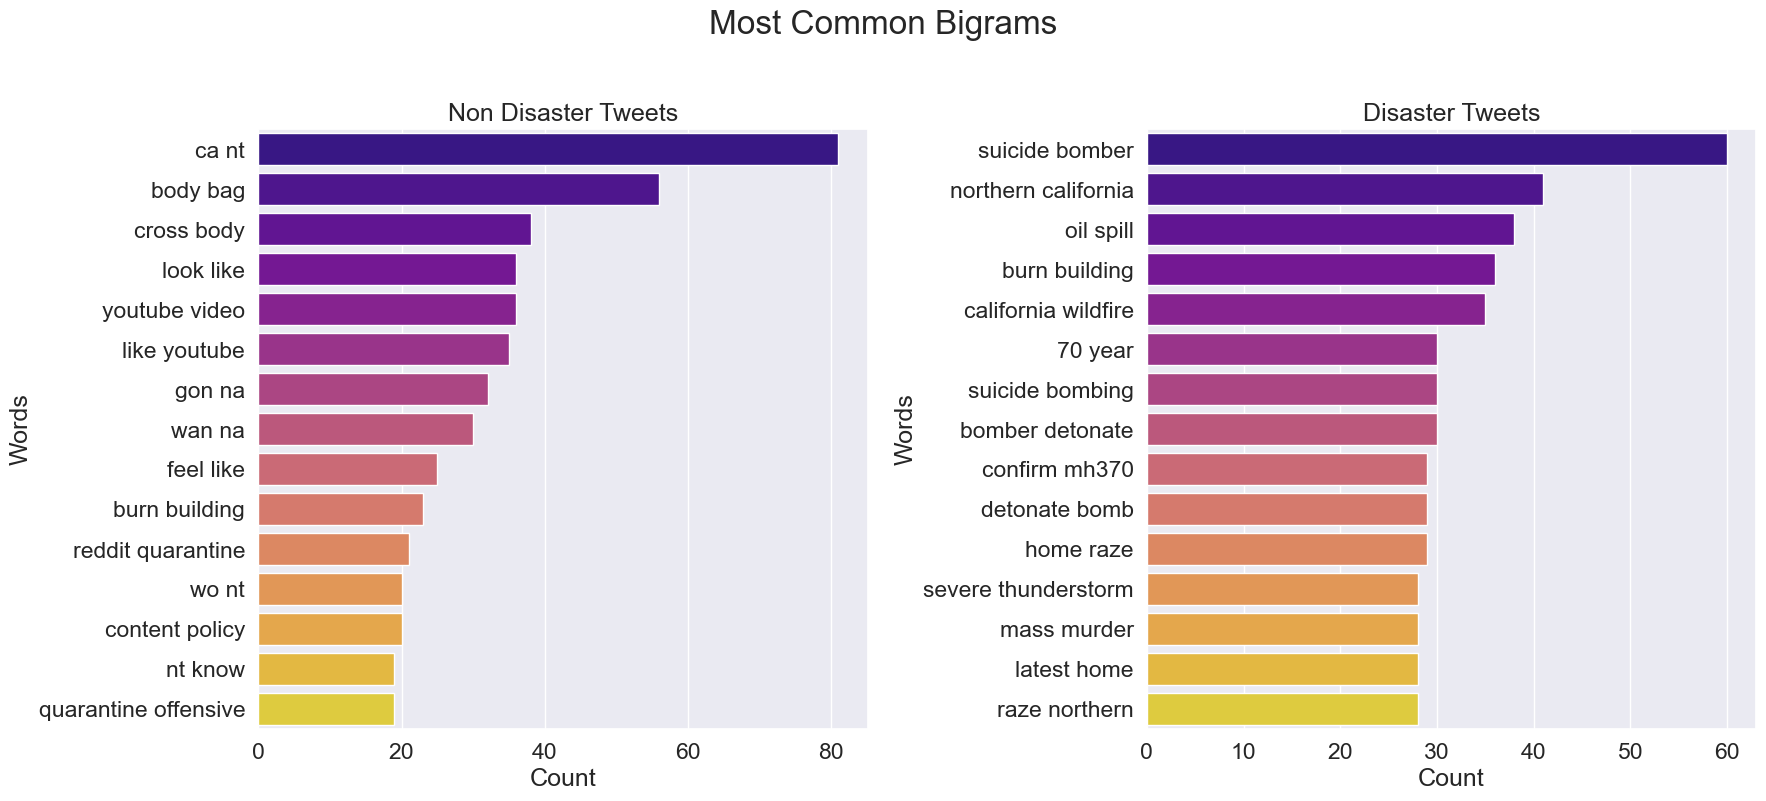

In [ ]:
ngrams(2, 'Most Common Bigrams')

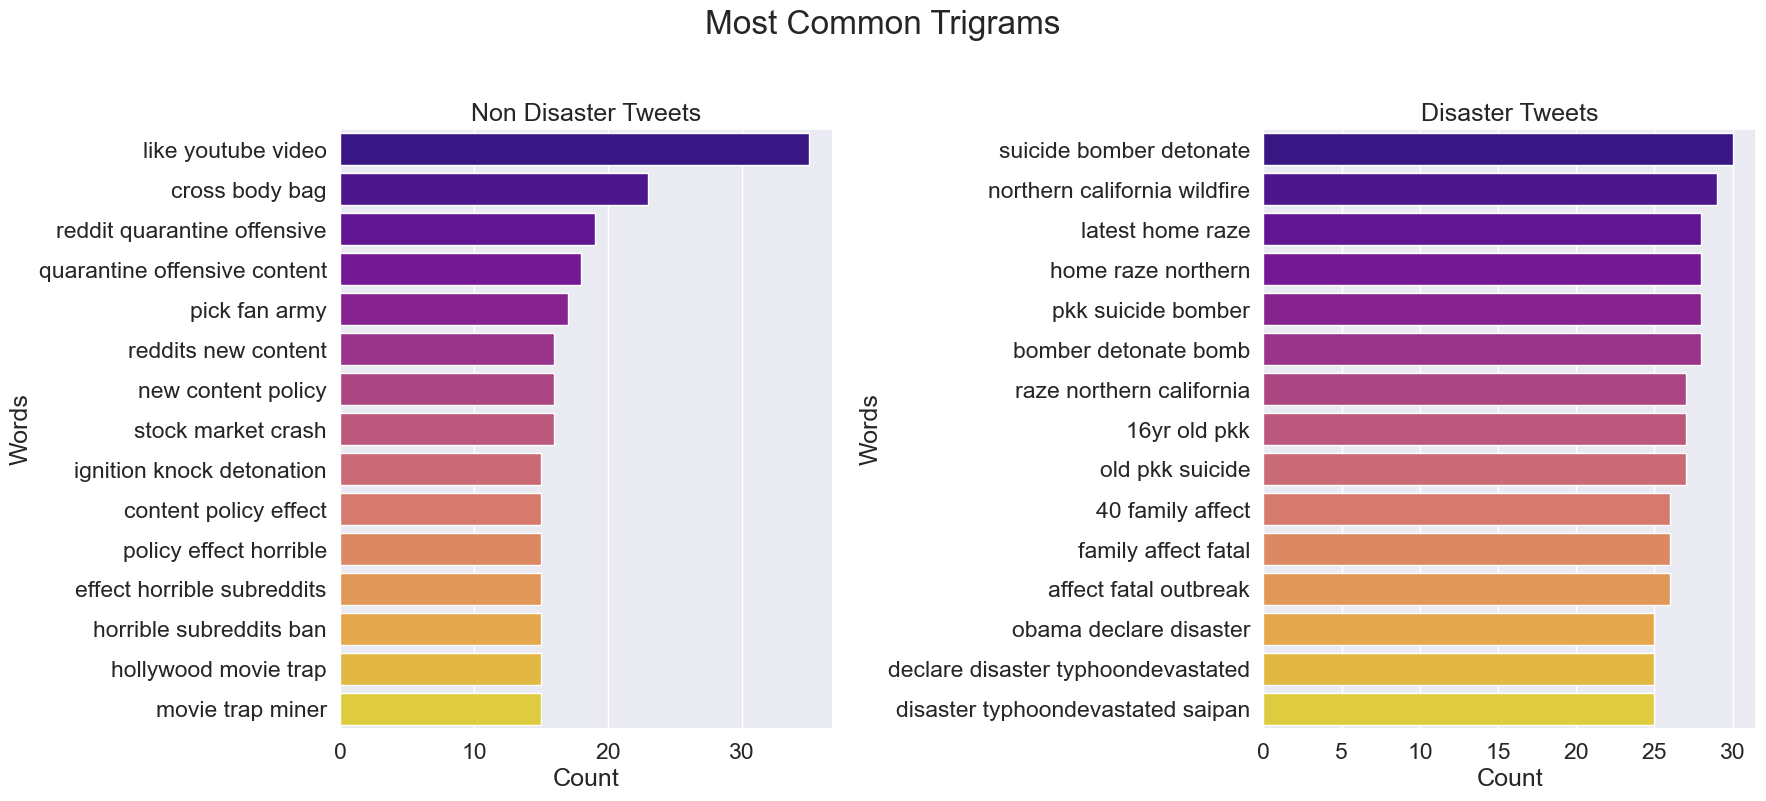

In [ ]:
ngrams(3, 'Most Common Trigrams')

In [ ]:
def display_topics(text, no_top_words, topic):
    """ A function for determining the topics present in our corpus with nmf """

    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    # Updated to use get_feature_names_out()
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=10, random_state=0,
              init='nndsvd', solver='cd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Call the function for both disaster and non-disaster topics


In [ ]:
display_topics(trainv[trainv['target'] == 0]['lemma_str'], 10, 'Non Disaster Topics\n')


Non Disaster Topics

Topic 1:
nt ca know think still even say drown let sink
Topic 2:
like video youtube look feel sink back fatality mudslide take
Topic 3:
get blow day demolish life bomb lol good think na
Topic 4:
new emergency full content read quarantine post many storm service
Topic 5:
scream hear face phone fuck song time loud baby hit
Topic 6:
body bag cross shoulder full lady read ebay really rt
Topic 7:
via youtube god change obliteration news story video stop service
Topic 8:
go make one let explode time see day people wreck
Topic 9:
fire burn building emergency plan service sure save see put
Topic 10:
love crush woman collide see much would run day still


In [ ]:
display_topics(trainv[trainv['target'] == 1]['lemma_str'], 10, 'Disaster Topics\n')

Disaster Topics

Topic 1:
fire forest truck wild evacuate california service set evacuation say
Topic 2:
suicide bomb bombing hiroshima atomic bomber detonate japan old kill
Topic 3:
via attack wave israeli evacuation heat police post stop terrorist
Topic 4:
nt get like watch go minute sandstorm swallow airport look
Topic 5:
crash kill police train accident helicopter fear flood air say
Topic 6:
california wildfire home northern news latest raze abc collapse oil
Topic 7:
burn building live like collapse two people car riot video
Topic 8:
disaster nuclear obama natural declare saipan typhoondevastated sign northern collapse
Topic 9:
mh370 family confirm malaysia wreckage pm debris conclusively investigator find
Topic 10:
storm violent video severe wind thunderstorm land warning rain weather


In [ ]:
mask = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/pnghq.com-x-full-clarity-png-visual-5.png'))
mask[mask.sum(axis=2) == 0] = 255

In [ ]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='grey',
    ).generate(str(mostcommon))

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

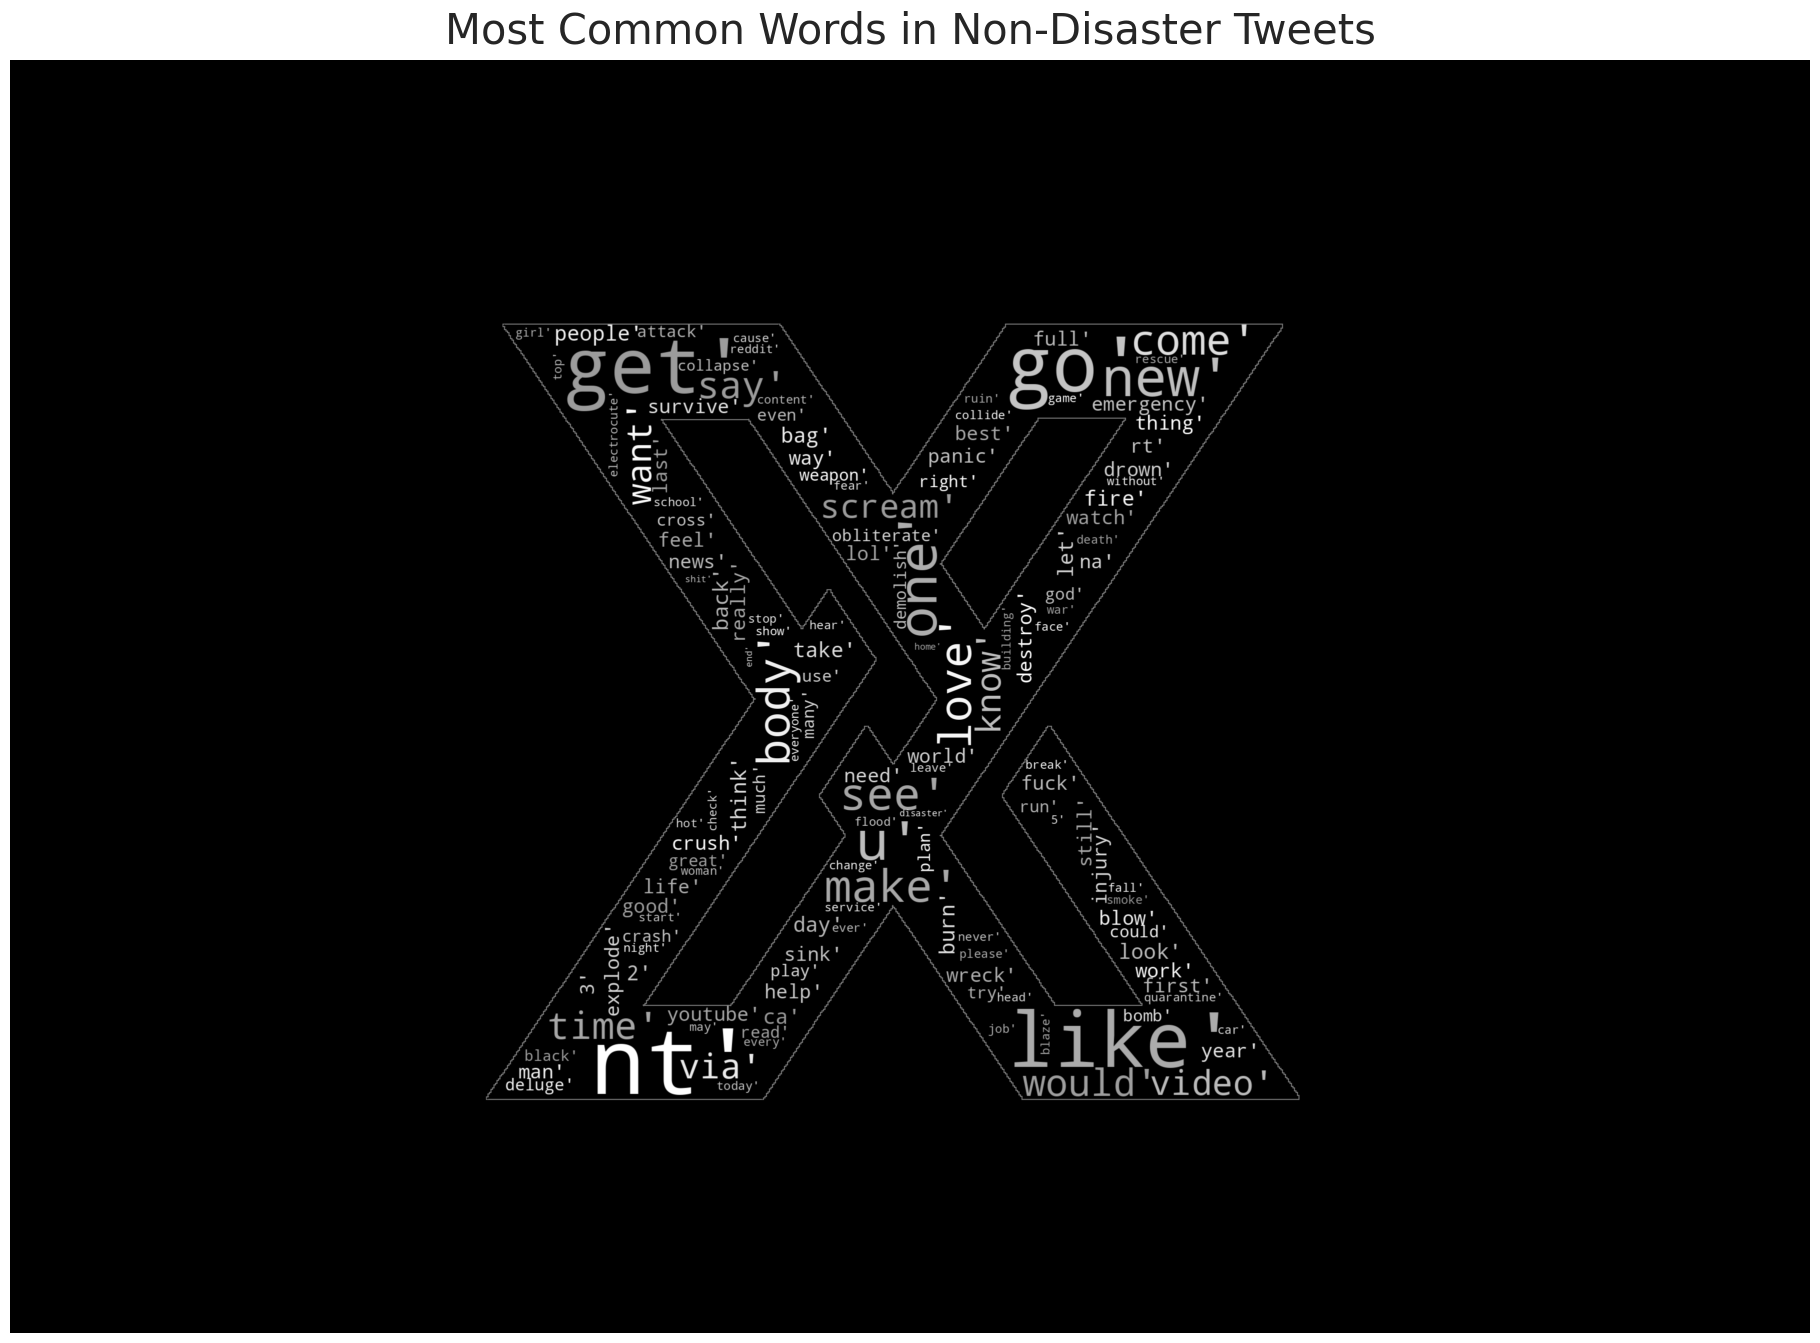

In [ ]:
plot_wordcloud(trainv[trainv['target'] == 0]['lemmatized'],
               'Most Common Words in Non-Disaster Tweets',
               title_size=30)

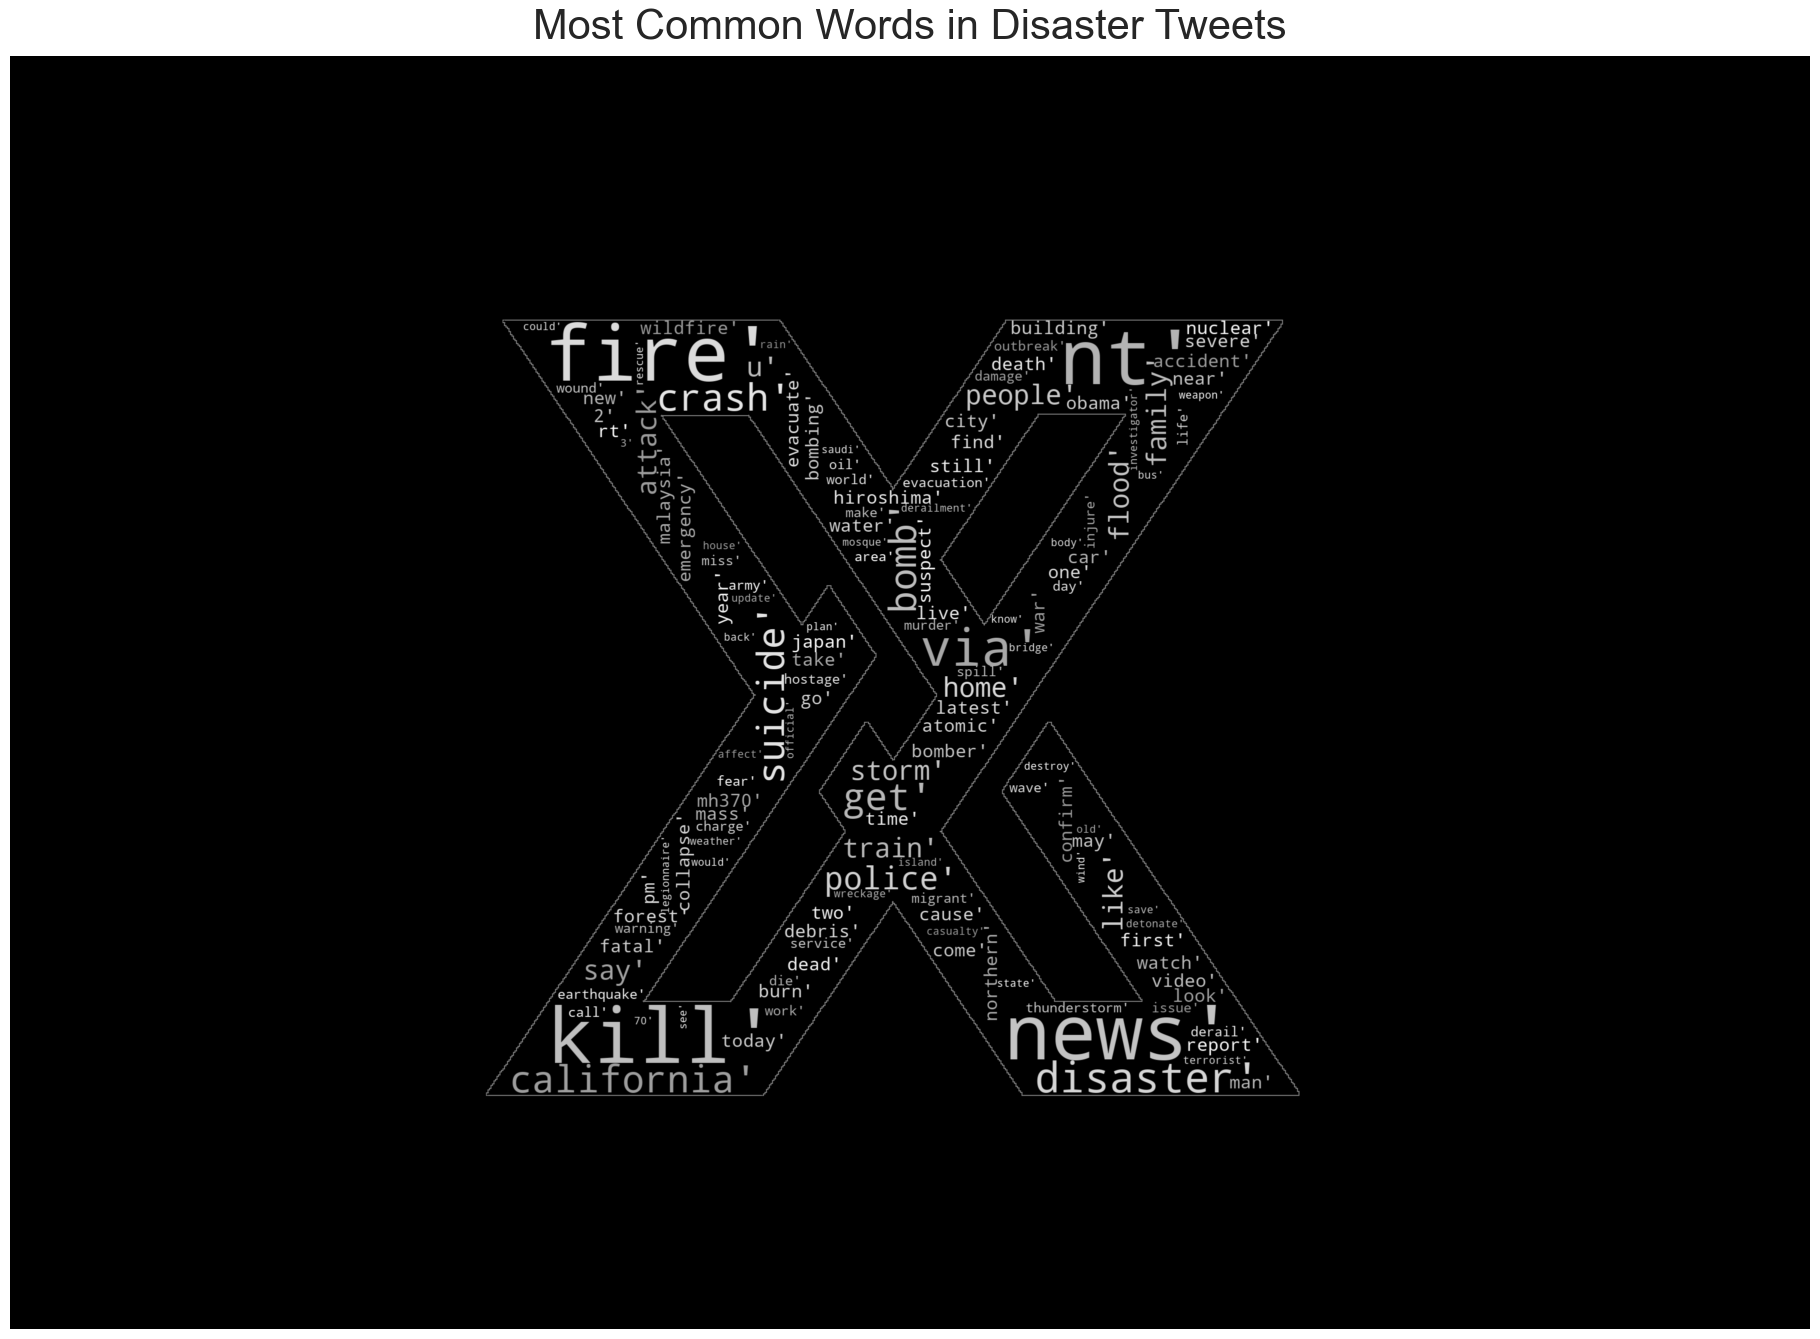

In [ ]:
plot_wordcloud(trainv[trainv['target'] == 1]['lemmatized'],
               'Most Common Words in Disaster Tweets',
               title_size=30)

In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
def plot_named_entity_barchart(text):

    """A function for extracting named entities and comparing them"""

    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

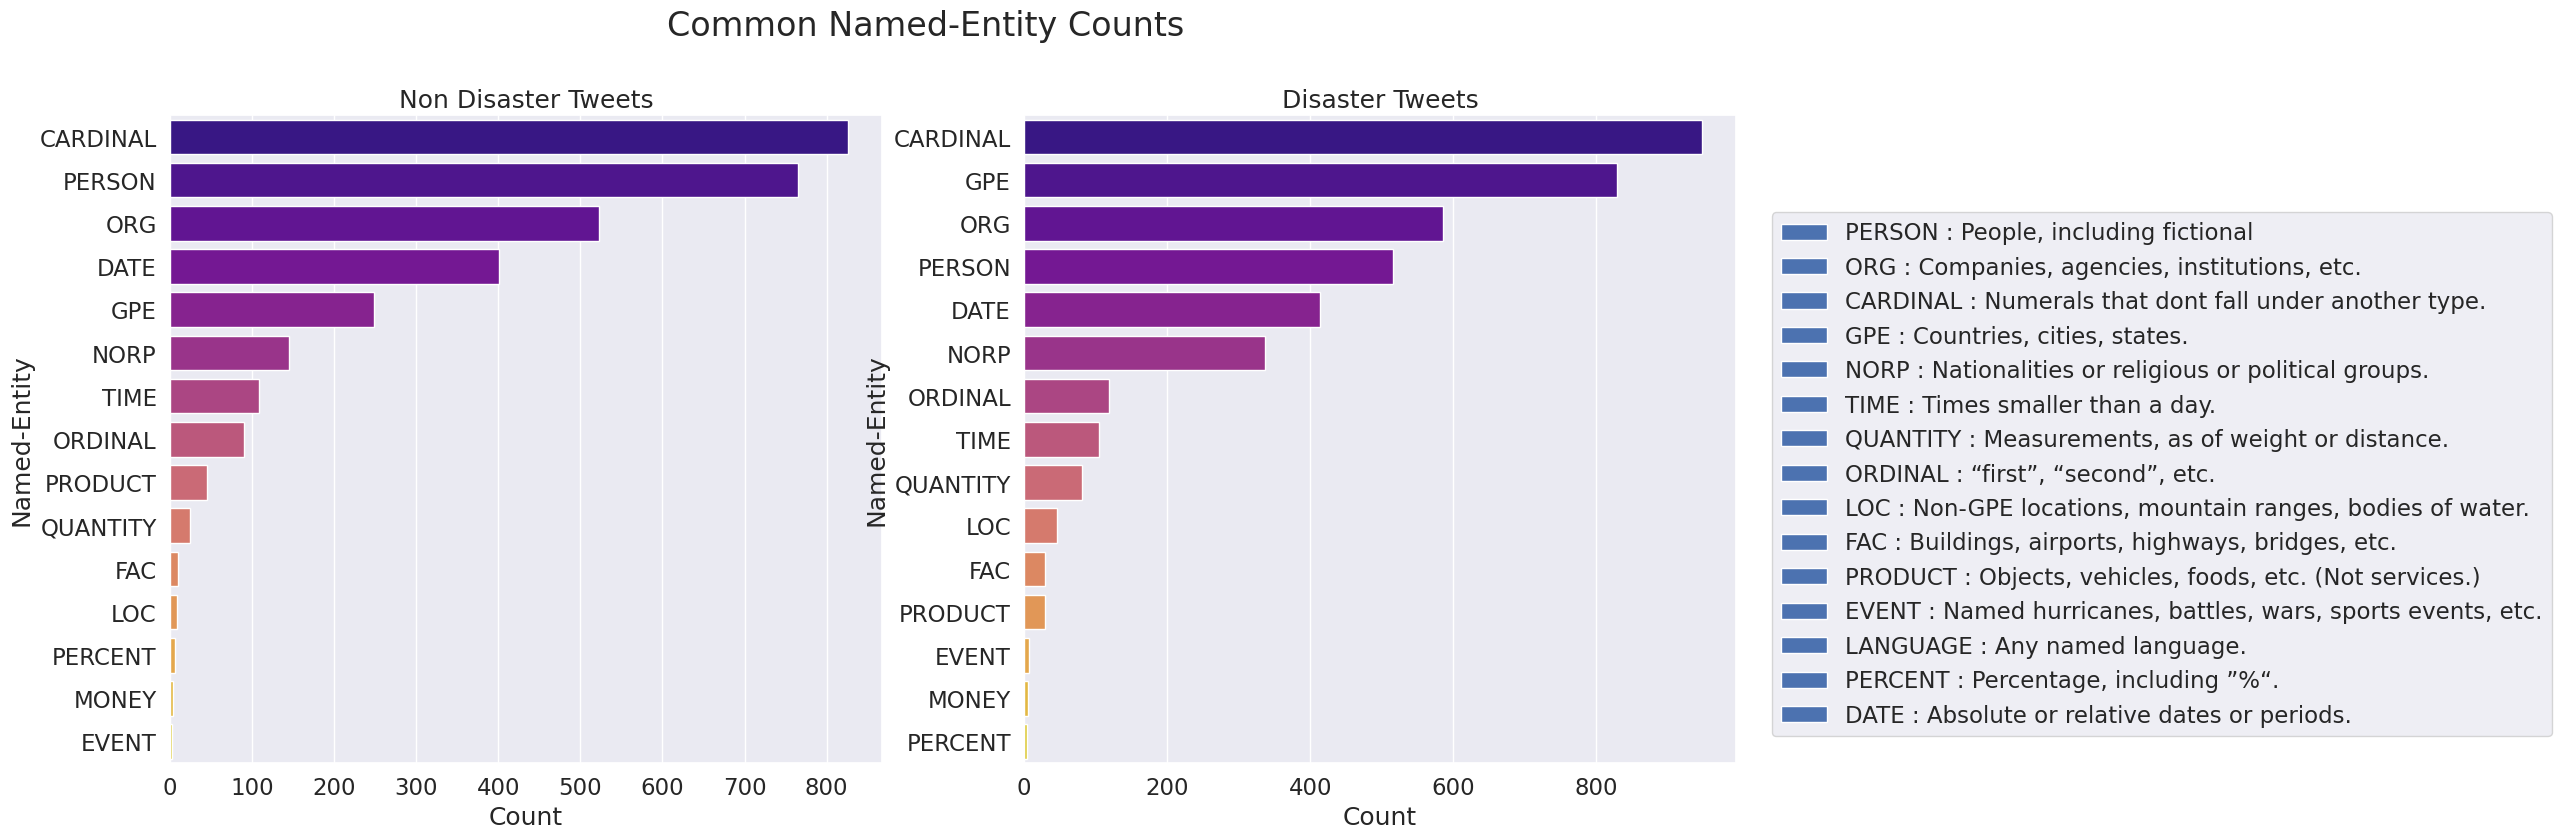

In [ ]:
# First define the list of disaster and non-disaster tweets
lis = [
    trainv[trainv['target'] == 0]['lemma_str'],
    trainv[trainv['target'] == 1]['lemma_str']
]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.

    device = torch.device('cuda')


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train (1).csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test (2).csv')

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(10))

Number of training tweets: 7613

Number of training tweets: 3263



,id,keyword,location,text,target
217,309,annihilated,"Greater Manchester, UK",@ACarewornHeart Have a good un fella sorry I w...,0
6688,9582,thunder,NaN,Thunder lightening torrential rain and a power...,1
2687,3855,detonation,NaN,Dorman 917-033 Ignition Knock (Detonation) Sen...,1
5060,7211,natural%20disaster,liaÛ¢daniÛ¢laura,Rise up like a natural disaster we take the ba...,0
6855,9826,trauma,NaN,Trauma injuries involving kids and sport usual...,1
563,814,battle,NaN,A young German stormtrooper engaged in the Bat...,1
2431,3493,derailed,United Kingdom,#tubestrike derailed you? Our #robertwelch cut...,0
2928,4209,drowned,NaN,@ABCNews24 @PeterDutton_MP \nHe also told you....,0
3400,4868,explode,London / Berlin / Online,'I eat because it makes my mouth explode with ...,0
6258,8942,storm,NaN,FINALLY a storm,0


In [ ]:
labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
# Create combined from train and test text data
combined = pd.concat([train, test])
combined = combined.text.values

print(' Original: ', combined[0])

# Print the tweet split into tokens.
print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [ ]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [ ]:
token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


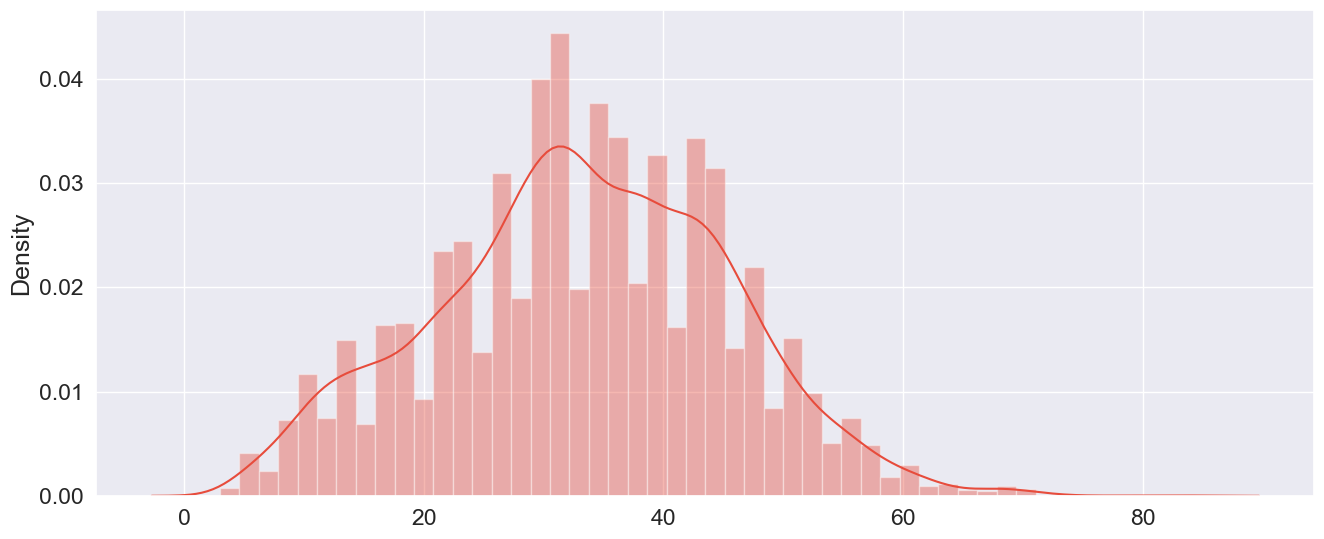

In [ ]:
fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

In [ ]:
# Get labels from train DataFrame
labels = train['target'].values

# Define idx as the length of labels
idx = len(labels)

# Split combined data into train and test
train = combined[:idx]
test = combined[idx:]

# Print shape of training data
train.shape

(7613,)

In [ ]:
def tokenize_map(sentence,labs='None'):

    """A function for tokenize all of the sentences and map the tokens to their word IDs."""

    global labels

    input_ids = []
    attention_masks = []

    # For every sentence...

    for text in sentence:
        #   "encode_plus" will:

        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list.

        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).

        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [ ]:
# Tokenize train data with labels
input_ids, attention_masks, labels = tokenize_map(train, 'labels')

# Tokenize test data without labels
test_input_ids, test_attention_masks = tokenize_map(test, 'None')

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


In [ ]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [ ]:
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):

    """A function for calculating accuracy scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):

    """A function for calculating f1 scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return f1_score(labels_flat, pred_flat)

In [ ]:
def format_time(elapsed):

    """A function that takes a time in seconds and returns a string hh:mm:ss"""

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#train the model

In [ ]:
import time
import torch

# Function to format time
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Initialize training stats
training_stats = []

# Measure total training time
total_t0 = time.time()

# Training loop
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()  # Set model to training mode

    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 batches
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Move batch to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear gradients
        model.zero_grad()

        # Forward pass
        outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate loss
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epoch took: {:}'.format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print('')
    print('Running Validation...')

    t0 = time.time()
    model.eval()  # Set model to evaluation mode

    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0

    for batch in validation_dataloader:
        # Move batch to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

        # Accumulate validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU for metrics
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate metrics
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)

    # Calculate validation metrics
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    print('  F1: {0:.2f}'.format(avg_val_f1))
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record stats
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Val_F1': avg_val_f1,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print('')
print('Training complete!')
print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:01:15.
  Batch   100  of    191.    Elapsed: 0:02:30.
  Batch   150  of    191.    Elapsed: 0:03:46.

  Average training loss: 0.37
  Training epoch took: 0:04:48

Running Validation...
  Accuracy: 0.82
  F1: 0.78
  Validation Loss: 0.43
  Validation took: 0:00:25

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:01:15.
  Batch   100  of    191.    Elapsed: 0:02:31.
  Batch   150  of    191.    Elapsed: 0:03:47.

  Average training loss: 0.33
  Training epoch took: 0:04:49

Running Validation...
  Accuracy: 0.82
  F1: 0.77
  Validation Loss: 0.42
  Validation took: 0:00:25

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:01:15.
  Batch   100  of    191.    Elapsed: 0:02:31.
  Batch   150  of    191.    Elapsed: 0:03:47.

  Average training loss: 0.31
  Training epoch took: 0:04:49

Running Validation...
  Accuracy: 0.82
  F1: 0.77
  Valid

In [ ]:
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')

# Display the table.

display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.37,0.43,0.82,0.78,0:04:48,0:00:25
2,0.33,0.42,0.82,0.77,0:04:49,0:00:25
3,0.31,0.42,0.82,0.77,0:04:49,0:00:25


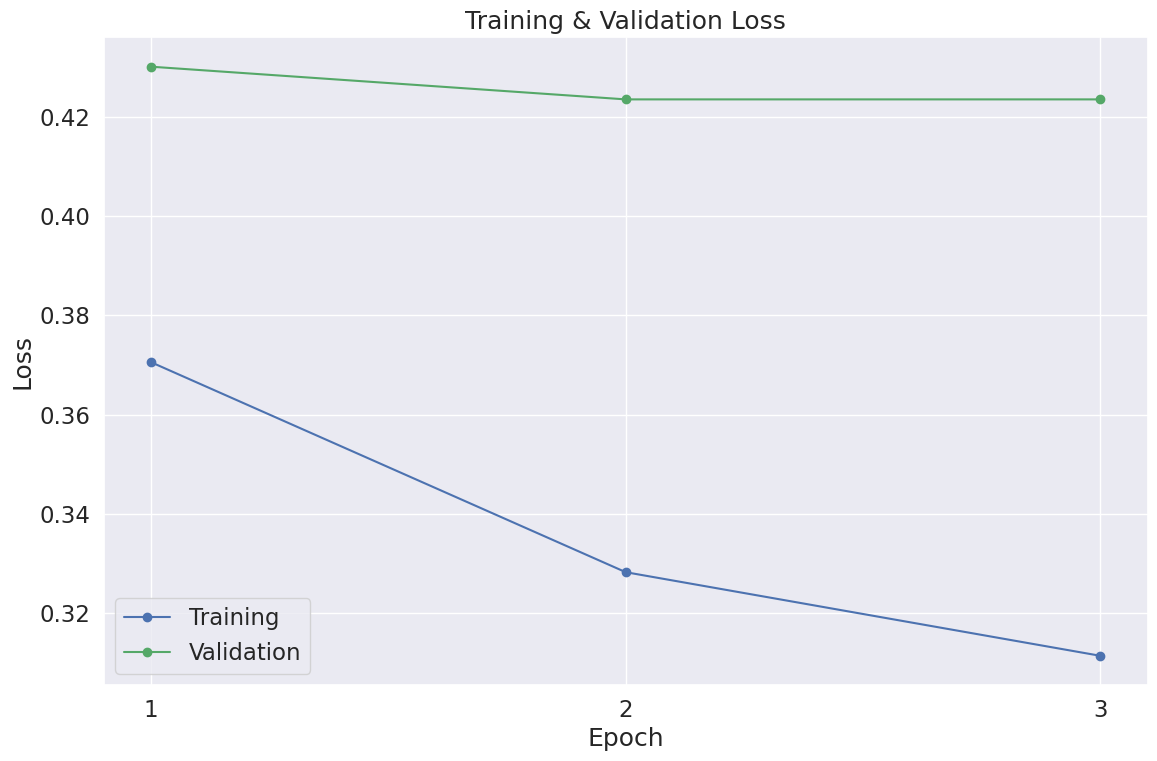

In [ ]:
fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [ ]:
# Prediction on test set:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode:

model.eval()

# Tracking variables :

predictions = []

# Predict:

for batch in prediction_dataloader:

  # Add batch to GPU

  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader:

  b_input_ids, b_input_mask, = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:

  with torch.no_grad():
      # Forward pass, calculate logit predictions:

      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU:

  logits = logits.detach().cpu().numpy()


  # Store predictions and true labels:

  predictions.append(logits)


print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')
submission['target'] = flat_predictions
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
submission.to_csv('submission.csv', index=False, header=True)


In [ ]:
model_path = "/content/drive/MyDrive/model.pth"  # مسار الحفظ في Google Drive
torch.save(model.state_dict(), model_path)
print("Model saved successfully!")

Model saved successfully!


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/model.pth"))
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Initialize the model architecture first
model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Load your trained weights
model_path = '/content/drive/MyDrive/model.pth'  # Update this path if needed
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def classify_tweet(tweet_text):
    # Tokenize the input text
    encoded_dict = tokenizer.encode_plus(
        tweet_text,
        add_special_tokens=True,
        max_length=84,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Move tensors to the appropriate device
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get probabilities and prediction
    logits = outputs[0]
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = torch.max(probabilities).item()

    return {
        'tweet': tweet_text,
        'prediction': 'Disaster' if predicted_class == 1 else 'Not Disaster',
        'confidence': f"{confidence*100:.2f}%",
        'raw_output': {
            'class_0_prob': probabilities[0][0].item(),
            'class_1_prob': probabilities[0][1].item()
        }
    }

In [ ]:
# Example usage
tweet_list = [
    # Disaster Tweets (should predict 1)
    "🌪️ Tornado warning issued for downtown! Seek shelter immediately! #SevereWeather #Emergency",
    "🔥 Wildfire evacuation order for Santa Rosa - winds shifting, danger increasing #CAfires",
    "🚨 BREAKING: Earthquake magnitude 6.1 strikes near Manila, buildings damaged #Philippines",
    "💥 Chemical plant explosion reported - authorities ordering 2-mile evacuation radius #Disaster",
    "🚑 Mass casualty accident on I-5 involving 15 vehicles - avoid area #TrafficAlert",
    "🌊 Catastrophic flooding in Pakistan - 1 million displaced, urgent aid needed #ClimateEmergency",
    "⚠️ Active shooter situation at high school - police responding #SecurityAlert",
    "☢️ Radiation leak detected at nuclear facility - shelter in place ordered #BreakingNews",
    "✈️ Plane crash near airport - emergency crews responding to scene #AviationDisaster",
    "🏚️ Apartment building collapse in Miami - rescue teams searching rubble #BuildingCollapse",

    # Non-Disaster Tweets (should predict 0)
    "📢 Just released my new song! Check it out y'all 🎶 #NewMusicFriday",
    "🍔 Burger or pizza? The eternal debate for lunch today... #FoodieThoughts",
    "☕ Perfect morning: coffee, sunshine, and a good book. What's your ideal morning? #MorningVibes",
    "🎬 Rewatching Lord of the Rings trilogy this weekend - never gets old! #MovieNight",
    "🚀 Amazing new Hubble telescope images of distant nebula released today #Space",
    "⚽ Game day! Who's watching the championship match tonight? #Sports",
    "📚 Just finished 'Project Hail Mary' - highly recommend! #BookRecommendations",
    "🎨 Spent the afternoon painting - so therapeutic! #ArtTherapy",
    "🐶 My dog just learned to shake hands - proud pet parent moment! #Pets",
    "😂 This meme had me crying with laughter today! #Funny",

    # Borderline/Challenging Cases
    "The new action movie's explosion scenes were FIRE! 🔥 #MovieEffects",  # Not real (0)
    "Literal fire in my kitchen right now - called 911! 🔥🚒",  # Real disaster (1)
    "That concert was explosive! Best performance ever! 💥",  # Metaphorical (0)
    "Gas explosion reported at downtown restaurant - multiple injuries",  # Real (1)
    "This heatwave is killing me! 🥵 #Summer",  # Metaphorical (0)
    "Heatwave causes record deaths in elderly population - state of emergency",  # Real (1)
    "My phone battery died - this is a total disaster! 😭",  # Metaphorical (0)
    "Nuclear plant cooling system failure reported - officials monitoring",  # Real (1)
    "That test was a complete trainwreck! #SchoolProblems",  # Metaphorical (0)
    "Train derailment with hazardous material spill - 10 mile evacuation"  # Real (1)
]

for tweet in tweet_list:
    result = classify_tweet(tweet)
    print(f"\nTweet: {result['tweet']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']}")
    print("-" * 50)


Tweet: 🌪️ Tornado warning issued for downtown! Seek shelter immediately! #SevereWeather #Emergency
Prediction: Disaster
Confidence: 95.71%
--------------------------------------------------

Tweet: 🔥 Wildfire evacuation order for Santa Rosa - winds shifting, danger increasing #CAfires
Prediction: Disaster
Confidence: 95.82%
--------------------------------------------------

Tweet: 🚨 BREAKING: Earthquake magnitude 6.1 strikes near Manila, buildings damaged #Philippines
Prediction: Disaster
Confidence: 95.72%
--------------------------------------------------

Tweet: 💥 Chemical plant explosion reported - authorities ordering 2-mile evacuation radius #Disaster
Prediction: Disaster
Confidence: 95.75%
--------------------------------------------------

Tweet: 🚑 Mass casualty accident on I-5 involving 15 vehicles - avoid area #TrafficAlert
Prediction: Disaster
Confidence: 96.19%
--------------------------------------------------

Tweet: 🌊 Catastrophic flooding in Pakistan - 1 million displ